In [1]:
import evadb
cursor = evadb.connect().cursor()

Downloading: "http://ml.cs.tsinghua.edu.cn/~chenxi/pytorch-models/mnist-b07bb66b.pth" to /Users/khushitalesra/.cache/torch/hub/checkpoints/mnist-b07bb66b.pth
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /Users/khushitalesra/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


In [2]:
!wget -nc "https://www.dropbox.com/s/k00wge9exwkfxz6/ua_detrac.mp4?raw=1" -O ua_detrac.mp4

zsh:1: command not found: wget


In [2]:
cursor.query('DROP TABLE IF EXISTS VideoForSegmentation;').df()
cursor.query('LOAD VIDEO "https://www.dropbox.com/s/k00wge9exwkfxz6/ua_detrac.mp4?raw=1" INTO VideoForSegmentation;').df()

[webp @ 0x176cf4af0] image data not found


,0
0,Number of loaded VIDEO: 1


In [ ]:
pip install timm

Note: you may need to restart the kernel to use updated packages.


In [3]:
cursor.query("""CREATE UDF IF NOT EXISTS HFSegmentation
      TYPE HuggingFace
      'task' 'image-segmentation'
      'model' 'facebook/detr-resnet-50-panoptic';
      """).df()

,0
0,"UDF HFSegmentation already exists, nothing added."


In [4]:
response = cursor.query("""SELECT HFSegmentation(data)
                  FROM VideoForSegmentation SAMPLE 5
                  WHERE id < 20;""").df()

[webp @ 0x1787855d0] image data not found
[buffer @ 0x178785a30] Unable to parse option value "0x0" as image size
[buffer @ 0x178785a30] Error setting option video_size to value 0x0.
[in @ 0x178785980] Error applying options to the filter.
08-26-2023 08:29:09 ERROR [plan_executor:plan_executor.py:execute_plan:0169] [08:29:09] /Users/suryatej/Downloads/Project/eva-decord/src/video/ffmpeg/filter_graph.cc:61: Check failed: avfilter_graph_create_filter(&buffersrc_ctx_, buffersrc, "in", args, __null, filter_graph_.get()) >= 0 (-22 vs. 0) Cannot create buffer source
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/evadb/executor/plan_executor.py", line 165, in execute_plan
    yield from output
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/evadb/executor/project_executor.py", line 33, in exec
    for batch in child_executor.exec(**kwargs):
  File "/Library/Frameworks/Python.fra

ExecutorError: [08:29:09] /Users/suryatej/Downloads/Project/eva-decord/src/video/ffmpeg/filter_graph.cc:61: Check failed: avfilter_graph_create_filter(&buffersrc_ctx_, buffersrc, "in", args, __null, filter_graph_.get()) >= 0 (-22 vs. 0) Cannot create buffer source

In [8]:
pip install matplotlib

  Obtaining dependency information for matplotlib from https://files.pythonhosted.org/packages/f6/22/9c31044ff7339c63727a135872e5cb59564f11625372a81c3eebf148f4af/matplotlib-3.7.2-cp311-cp311-macosx_11_0_arm64.whl.metadata
  Obtaining dependency information for contourpy>=1.0.1 from https://files.pythonhosted.org/packages/88/e3/696e96ee197b1f60242d12b215332af9fc1961c81990c8b5630b89b34ce6/contourpy-1.1.0-cp311-cp311-macosx_11_0_arm64.whl.metadata
  Obtaining dependency information for fonttools>=4.22.0 from https://files.pythonhosted.org/packages/1f/80/c5ce42faa7dec3c22fe587e56e141c7416c19a13a96bd4972bf1b55cb494/fonttools-4.42.1-cp311-cp311-macosx_10_9_universal2.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.0/151.0 kB 4.0 MB/s eta 0:00:00a 0:00:01
  Obtaining dependency information for kiwisolver>=1.0.1 from https://files.pythonhosted.org/packages/4a/fe/23d7fa78f7c66086d196406beb1fb2eaf629dd7adc01c3453033303d17fa/kiwisolver-1.4.5-cp311-cp311-macosx_11_0_arm64.whl.metadat

In [11]:
import numpy as np
from PIL import Image
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import cv2

def get_color_mapping(all_labels):
    unique_labels = set(label for labels in all_labels for label in labels)
    num_colors = len(unique_labels)
    colormap = plt.colormaps["tab20"]
    colors = [colormap(i % 20)[:3] for i in range(num_colors)]
    colors = [tuple(int(c * 255) for c in color) for color in colors]
    color_mapping = {label: color for label, color in zip(unique_labels, colors)}
    return  color_mapping

def annotate_single_frame(frame, segments, labels, color_mapping):
    overlay = np.zeros_like(frame)

    # Overlay segments
    for mask, label in zip(segments, labels):
        mask_np = np.array(mask).astype(bool)
        overlay[mask_np] = color_mapping[label]

    # Combine original frame with overlay
    new_frame = Image.blend(
        Image.fromarray(frame.astype(np.uint8)),
        Image.fromarray(overlay.astype(np.uint8)),
        alpha=0.5,
    )

    return new_frame

def annotate_video(segmentations, input_video_path, output_video_path, model_name = 'hfsegmentation'):
    all_segments = segmentations[f'{model_name}.mask']
    all_labels = segmentations[f'{model_name}.label']


    color_mapping = get_color_mapping(all_labels)

    vcap = cv2.VideoCapture(input_video_path)
    width = int(vcap.get(3))
    height = int(vcap.get(4))
    fps = vcap.get(5)
    fourcc = cv2.VideoWriter_fourcc('m', 'p', '4', 'v') #codec
    video=cv2.VideoWriter(output_video_path, fourcc, fps, (width,height))

    frame_id = 0
    ret, frame = vcap.read() 
    while ret and frame_id < len(all_segments):
        segments = all_segments[frame_id]
        labels = all_labels[frame_id]
        new_frame = annotate_single_frame(frame, segments, labels, color_mapping)
        video.write(np.array(new_frame))
        if frame_id % 5 == 0:
            legend_patches = [mpatches.Patch(color=np.array(color_mapping[label])/255, label=label) for label in set(labels)]
            plt.imshow(new_frame)
            plt.legend(handles=legend_patches, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
            plt.axis('off')
            plt.tight_layout()
            plt.show()


        frame_id += 1
        ret, frame = vcap.read()

    video.release()
    vcap.release()

In [11]:
pip install ipywidgets

  Obtaining dependency information for ipywidgets from https://files.pythonhosted.org/packages/b8/d4/ce436660098b2f456e2b8fdf76d4f33cbc3766c874c4aa2f772c7a5e943f/ipywidgets-8.1.0-py3-none-any.whl.metadata
  Obtaining dependency information for widgetsnbextension~=4.0.7 from https://files.pythonhosted.org/packages/8e/d4/d31b12ac0b87e8cc9fdb6ea1eb6596de405eaaa2f25606aaa755d0eebbc0/widgetsnbextension-4.0.8-py3-none-any.whl.metadata
  Obtaining dependency information for jupyterlab-widgets~=3.0.7 from https://files.pythonhosted.org/packages/74/5e/2475ac62faf2e342b2bf20b8d8e375f49400ecb38f52e4e0a7557eb1cedb/jupyterlab_widgets-3.0.8-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 3.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.0/215.0 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 7.6 MB/s eta 0:00:00a 0:00:01m
Note: you may need to restart the kernel to use updated packages.


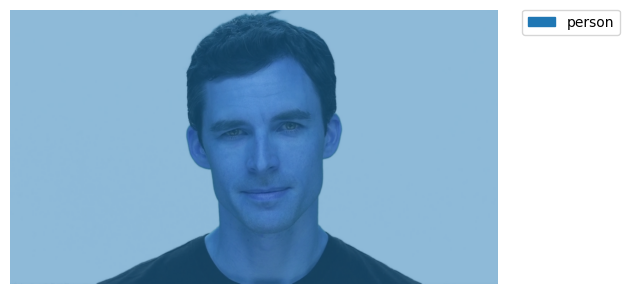

Video(value=b'\x00\x00\x00\x1cftypisom\x00\x00\x02\x00isomiso2mp41\x00\x00\x00\x08free\x00\x00\xd1\xc8...')

In [14]:
from ipywidgets import Video
input_path = 'Actor_01/01-02-01-01-01-01-01.mp4'
output_path = 'video.mp4'

annotate_video(response, input_path, output_path)
Video.from_file(output_path)